# P1 - Mini-Max Checkers - Fox and Hound '45

### Group 19
### Christopher Pawlenok

<u>Game Rules</u>

In this game, there are two players, Fox and the Hounds. The Fox has one piece that can move up, down, left, or right as long as the space is empty. While the Fox is trying to reach the farthest end of the board, the Hounds player is trying to stop it. If the Hounds "trap" the Fox into a situation where they don't have any more moves, then the Hounds player wins. If the Fox reaches the far end of the board, then the Fox player wins. No player piece can “jump” over the other or remove a piece. The Fox always goes first. Turns alternate until either the Fox runs out of valid spaces to move

* The game must use a 6x6 board that is turned diagonally (see illustration).
* There is one fox piece that is initially placed at the top of the board in a corner (i.e. at the very top).
* The goal of the fox player is to move to the bottom of the board (again a corner spot) and to get past the hounds.
* The fox can move in any empty dark square (i.e. top, down, left, right).
* There are four hounds. The hounds start on the bottom two dark row squares.
* Each hound can move in an empty dark square, but cannot move backwards (i.e. cannot move down).
* The goal of the hounds is to "trap" the fox by getting in its way.
* If the fox reaches the bottom of the board spot, then the hounds lose.



## 1. Import Requrired Libraries

*Create a GameBoard that manages the rules of the game, maintains the state of pieces, contains methods for getting available moves, renders the game*



In [1]:
import numpy as np
import math
import heapq
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

## 1. Gameboard

*Create a GameBoard that manages the rules of the game, maintains the state of pieces, contains methods for getting available moves, renders the game*

In [13]:
class GameBoard:
    def __init__(self):
        # 0 = empty, 1 = fox, 2 = hound
        self.board = np.zeros((6, 6), dtype=int)
        self.fox = None
        self.hounds = []
        self.fox_counter = 0
        self.hound_counter = 0

    # ----- helpers -----
    @staticmethod
    def in_bounds(r, c):
        return 0 <= r < 6 and 0 <= c < 6

    @staticmethod
    def is_dark(r, c):
        # define playable (dark) squares
        return (r + c) % 2 == 0  # top-left is dark

    def cell_empty(self, r, c):
        return self.board[r, c] == 0

    # ----- setup -----
    def start_game(self):
        """Initialize fox and hounds."""
        self.board.fill(0)

        # Fox starts at top-left corner (dark square)
        self.fox = (0, 0)
        self.board[self.fox] = 1

        # Four hounds near the bottom on dark squares (no overlap)
        # Chosen pattern: two on row 5 (cols 1,3) and two on row 4 (cols 0,2)
        start_hounds = [(5, 5), (5, 3), (4, 4), (3, 5)]
        self.hounds = []
        for r, c in start_hounds:
            assert self.is_dark(r, c), "Hound placed on a non-dark square!"
            assert self.cell_empty(r, c), "Overlapping piece!"
            self.hounds.append((r, c))
            self.board[r, c] = 2

    def gamestate(self):
        return self.fox, list(self.hounds),

    # ----- moves -----
    def get_fox_moves(self):
        """Return valid moves for fox (diamond-adjacent squares)."""
        moves = []
        r, c = self.fox
        # Fox moves: up, down, left, right (diamond) → 4 diagonals in array
        directions = [(-1, -1), (-1, +1), (+1, -1), (+1, +1)]
        for dr, dc in directions:
            nr, nc = r + dr, c + dc
            if self.in_bounds(nr, nc) and self.cell_empty(nr, nc) and self.is_dark(nr, nc):
                moves.append((nr, nc))
        return moves

    def get_fox_moves_from(self, pos):
      """Return valid fox moves from an arbitrary position."""
      moves = []
      r, c = pos
      directions = [(-1, -1), (-1, +1), (+1, -1), (+1, +1)]
      for dr, dc in directions:
          nr, nc = r + dr, c + dc
          if self.in_bounds(nr, nc) and self.cell_empty(nr, nc) and self.is_dark(nr, nc):
              moves.append((nr, nc))
      return moves

    def get_hound_moves(self, pos):
        """Return valid moves for one hound (no backward = no increasing row)."""
        moves = []
        r, c = pos
        # Hounds move diagonally upward-left, upward-right, or sideways-left
        # (adjust depending on your exact rules; here 'up' means row decreases)
        directions = [(-1, -1), (-1, +1), (+1, -1)]  # example: up-left, up-right, sideways
        for dr, dc in directions:
            nr, nc = r + dr, c + dc
            if self.in_bounds(nr, nc) and self.cell_empty(nr, nc) and self.is_dark(nr, nc):
                moves.append((nr, nc))
        return moves

    def check_winner(self):
      """
      Determine if the game has a winner.
      Returns: "fox", "hounds", or None
      """
      # 1. Fox reaches the bottom-right corner → fox wins
      if self.fox == (5, 5):
          return "fox", self.fox_counter

      # 2. Fox has no moves → hounds win
      if not self.get_fox_moves():
          return "hounds", self.hound_counter

      if len(self.get_fox_moves()) == 0:
          return "hounds", self.hound_counter
      # 3. Hounds have no moves → fox win
      possible_moves = []
      for i in range(len(self.hounds)):
        moves = self.get_hound_moves(self.hounds[i])
        for move in moves:
          possible_moves.append([i,move])

      if len(possible_moves) == 0:
        return "fox", self.fox_counter

      # 4. No winner yet
      return None, None

    def move_fox(self, new_pos):
        if new_pos in self.get_fox_moves():
            self.board[self.fox] = 0
            self.fox = new_pos
            self.board[new_pos] = 1
            self.fox_counter += 1
            return True
        return False

    def move_hound(self, i, new_pos):
        if not (0 <= i < len(self.hounds)):
            return False
        cur = self.hounds[i]
        if new_pos in self.get_hound_moves(cur):
            self.board[cur] = 0
            self.hounds[i] = new_pos
            self.board[new_pos] = 2
            self.hound_counter += 1
            return True
        return False

    def fox_shortest_path(self):
      """
      Dijkstra's algorithm for the fox.
      Returns the shortest path (list of coords) and its distance,
      or (None, inf) if unreachable.
      """
      start = self.fox
      goal = (5, 5)  # fox must reach bottom-right corner

      # Distance and predecessor maps
      dist = {start: 0}
      prev = {}

      # Priority queue
      pq = [(0, start)]

      while pq:
          d, u = heapq.heappop(pq)

          # If we reached the goal
          if u == goal:
              path = []
              cur = u
              while cur in prev:
                  path.append(cur)
                  cur = prev[cur]
              path.append(start)
              path.reverse()
              return path, d

          # Explore neighbors
          for v in self.get_fox_moves_from(u):
              alt = d + 1
              if v not in dist or alt < dist[v]:
                  dist[v] = alt
                  prev[v] = u
                  heapq.heappush(pq, (alt, v))

      # No path found
      return None, float("inf")

    def render_board(self):
      '''Render checkerboard rotated 45° (diamond orientation).'''
      fig, ax = plt.subplots(figsize=(6, 6))

      # Board center
      cx, cy = 2.5, 2.5
      angle = -3 * math.pi / 4  # -135° (i.e. -45° - 90°)

      def rotate(x, y):
          dx, dy = x - cx, y - cy
          rx = dx * math.cos(angle) - dy * math.sin(angle)
          ry = dx * math.sin(angle) + dy * math.cos(angle)
          return rx, ry

      # Collect bounds for axis scaling
      all_x, all_y = [], []

      # Draw squares
      for r in range(6):
          for c in range(6):
              color = "#bdbdbd" if self.is_dark(r, c) else "#ffffff"
              corners = [(c, r), (c+1, r), (c+1, r+1), (c, r+1)]
              rot_corners = [rotate(x, y) for (x, y) in corners]
              all_x.extend([pt[0] for pt in rot_corners])
              all_y.extend([pt[1] for pt in rot_corners])
              poly = patches.Polygon(rot_corners, facecolor=color, edgecolor="#888", linewidth=0.5)
              ax.add_patch(poly)

      # Draw fox
      if self.fox is not None:
          fr, fc = self.fox
          fx, fy = rotate(fc + 0.5, fr + 0.5)
          all_x.append(fx)
          all_y.append(fy)
          ax.add_patch(patches.Circle((fx, fy), 0.35, facecolor="red", edgecolor="black"))

      # Draw hounds
      for hr, hc in self.hounds:
          hx, hy = rotate(hc + 0.5, hr + 0.5)
          all_x.append(hx)
          all_y.append(hy)
          ax.add_patch(patches.Circle((hx, hy), 0.35, facecolor="black", edgecolor="black"))

      # Format: expand axis to include all rotated coords with margin
      min_x, max_x = min(all_x), max(all_x)
      min_y, max_y = min(all_y), max(all_y)
      margin = 0.5
      ax.set_xlim(min_x - margin, max_x + margin)
      ax.set_ylim(min_y - margin, max_y + margin)
      ax.set_aspect("equal")
      ax.axis("off")
      plt.show()

## 2. Random Fox and Hound AI

*Create the Random AIs for the fox and hound.*

In [5]:


def random_hound_turn(board):
  possible_moves = []
  #assign list move moves to array with label for corisponding hound
  for i in range(len(board.hounds)):
    moves = board.get_hound_moves(board.hounds[i])
    for move in moves:
      possible_moves.append([i,move])

  #if there are no moves which should be checked before this is called return None
  if len(possible_moves) == 0:
    return 1

  #pick move at random from array
  moveIndex = random.randint(0, len(possible_moves)-1)

  #call gameboard move function
  board.move_hound(possible_moves[moveIndex][0], possible_moves[moveIndex][1])
  winner, moves = board.check_winner()
  #return 1 if sucessful
  if winner is None:
    return "1", 1
  else:
    return winner, moves

def random_fox_turn(board):
  #get list of possible moves
  moves = board.get_fox_moves()
  #if there are no moves which should be checked before this is called return None
  if len(moves) == 0:
    return None
  #pick move at random
  moveIndex = random.randint(0, len(moves)-1)

  #call move fameboard move function
  board.move_fox(moves[moveIndex])
  winner, moves = board.check_winner()
  if winner is None:
    return "1", 1
  else:
    return winner, moves


## 3. Running the Game

*Create the logic for maintaining game state using the Random AIs to run the game.*

=== Initial Board ===


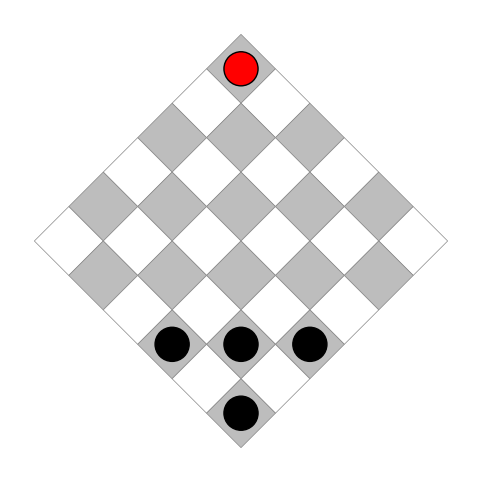

Fox: (0, 0)
Hounds: [(5, 5), (5, 3), (4, 4), (3, 5)]

Fox possible moves: [(1, 1)]
Moving fox to (1, 1)

Hound[0] possible moves: [(2, 4)]

=== Updated Board ===


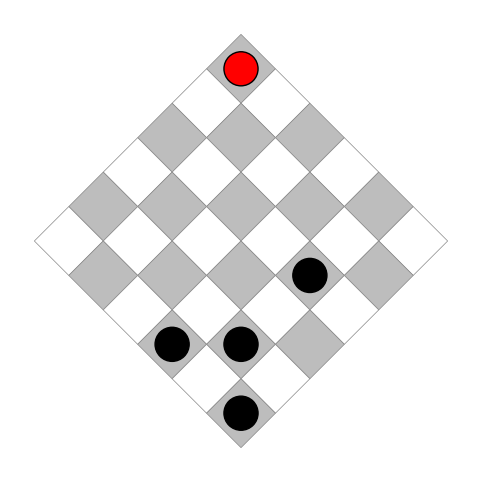

Fox: (0, 0)
Hounds: [(5, 5), (4, 2), (4, 4), (3, 5)]


In [6]:
# Quick test for GameBoard
gb = GameBoard()
gb.start_game()

print("=== Initial Board ===")
gb.render_board()
print("Fox:", gb.fox)
print("Hounds:", gb.hounds)

# Try moving the fox
fox_moves = gb.get_fox_moves()
print("\nFox possible moves:", fox_moves)
if fox_moves:
    print("Moving fox to", fox_moves[0])
    gb.move_fox(fox_moves[0])



# Try moving the first hound
hound_moves = gb.get_hound_moves(gb.hounds[3])
print("\nHound[0] possible moves:", hound_moves)
'''if hound_moves:
    print("Moving hound[0] to", hound_moves[0])
    gb.move_hound(1, hound_moves[0])'''
random_fox_turn(gb)
random_hound_turn(gb)

print("\n=== Updated Board ===")
gb.render_board()
print("Fox:", gb.fox)
print("Hounds:", gb.hounds)

## 4. Fox AI

*Create logic for the Fox AI (e.g. shortest path). This should win more against the Random Hounds AI.*

In [7]:
def Fox_ShortPath_AI(board):
    """
    Fox AI using Dijkstra shortest path.
    Moves the fox piece directly on the board.
    Returns 1 if a move was made, None if no moves are possible.
    """
    path, dist = board.fox_shortest_path()
    if path and len(path) > 1:
        # Move fox to the next step in the path
        board.move_fox(path[1])
        winner, moves = board.check_winner()
        if winner is None:
          return "1", 1
        else:
          return winner, moves
    else:
        # fallback: random move
        moves = board.get_fox_moves()
        if moves:
            move = random.choice(moves)
            board.move_fox(move)
            winner, moves = board.check_winner()
            if winner is None:
              return "1", 1
            else:
              return winner, moves
        return None, None  # no moves available


## 5. Hound AI

*Create logic for the Hounds AI using a Minimax approach.*

In [8]:
def Hound_Minimax_AI(board, depth=2):
    """
    Hound AI using Minimax algorithm with fixed depth.
    Returns 1 if a move was made, None if no moves are possible.
    """
    def minimax(board, depth, maximizing):
        winner = board.check_winner()
        if winner == "hounds":
            return 10 - depth
        elif winner == "fox":
            return depth - 10
        elif depth == 0:
            fox_r, fox_c = board.fox
            goal_distance = abs(5 - fox_r) + abs(5 - fox_c)
            fox_mobility = len(board.get_fox_moves())
            return goal_distance - fox_mobility * 0.5
        # HOUND MOVE
        if maximizing:
            max_eval = float('-inf')
            for i in range(len(board.hounds)):
                moves = board.get_hound_moves(board.hounds[i])
                for move in moves:
                    # Current State
                    old_pos = board.hounds[i]
                    board.board[old_pos] = 0
                    board.hounds[i] = move
                    board.board[move] = 2

                    # Recurse
                    eval = minimax(board, depth - 1, False)

                    # Restore state
                    board.board[move] = 0
                    board.hounds[i] = old_pos
                    board.board[old_pos] = 2

                    max_eval = max(max_eval, eval)
            return max_eval
        # FOX MOVE
        else:
            min_eval = float('inf')
            fox_moves = board.get_fox_moves()
            for move in fox_moves:
                # Current state
                old_pos = board.fox
                board.board[old_pos] = 0
                board.fox = move
                board.board[move] = 1

                # Recurse
                eval = minimax(board, depth - 1, True)

                # Restore state
                board.board[move] = 0
                board.fox = old_pos
                board.board[old_pos] = 1

                min_eval = min(min_eval, eval)
            return min_eval

    best_move = None
    best_value = float('-inf')

    for i in range(len(board.hounds)):
        moves = board.get_hound_moves(board.hounds[i])
        for move in moves:
            old_pos = board.hounds[i]
            board.board[old_pos] = 0
            board.hounds[i] = move
            board.board[move] = 2

            move_value = minimax(board, depth - 1, False)

            board.board[move] = 0
            board.hounds[i] = old_pos
            board.board[old_pos] = 2

            if move_value > best_value:
                best_value = move_value
                best_move = (i, move)

    if best_move:
        board.move_hound(best_move[0], best_move[1])
        winner, moves = board.check_winner()
        if winner is None:
          return "1", 1
        else:
          return winner, moves
    return None, None

## Testing

As you develop your game, you will need to eventually run 100 games across each condition. Since this is a 2x2 configuration, there are 4 possible conditions: random-random, random-ai, and ai-random, and ai-ai. Each game should record the condition, who won (fox or hounds player) and how many turns the game lasted until a player lost/won.


In [14]:
# from logging import raiseExceptions

# def run_game(fox_turn_func, hound_turn_func,render_board_flag):
#   gb = GameBoard()
#   gb.start_game()

#   if render_board_flag:
#     gb.render_board()

#   turn_counter = 0
#   winner = None

#   while winner == None:
#     turn_counter += 1
#     if (Fox_ShortPath_AI(gb) == None):
#       gb.render_board()
#       raise Exception("Hound failed to take turn") #This should never return None if it does the check_winner function failed
#     winner = gb.check_winner()
#     if winner[0] != None:
#       #print(winner)
#       break
#     if (Hound_Minimax_AI(gb) == None):
#       gb.render_board()
#       raise Exception("Hound failed to take turn") #This should never return None if it does the check_winner function failed
#     winner = gb.check_winner()
#     #print(winner)

#   print(gb.check_winner(),turn_counter)
#   if render_board_flag:
#     gb.render_board()
#   return (gb.check_winner(),turn_counter)


# def test100x(fox_turn_func, hound_turn_func):
#   for i in range(100):
#     run_game(fox_turn_func, hound_turn_func, 0)


# run_game(random_fox_turn, random_hound_turn, 1)
# # test100x(random_fox_turn, random_hound_turn)
# # test100x(random_fox_turn, '''mini_max_turn''')
# # test100x('''shortPath''', random_hound_turn)
# test100x(random_fox_turn, '''mini_max_turn''')

def run_matchup(fox_func, hound_func, num_games=100, max_turns=500):
    """
    Run a matchup between a fox function and a hound function.
    fox_func and hound_func each execute ONE TURN and return:
      (1, 1) -> game continues
      ("fox" or "hounds", moves) -> game over, record winner
      (None, None) -> error / invalid state
    """
    results = []

    for _ in range(num_games):
        board = GameBoard()
        board.start_game()

        turn_count = 0
        winner = None
        total_moves = 0

        while turn_count < max_turns:
            # --- Fox turn ---
            res, moves = fox_func(board)
            if res == 1 and moves == 1:
                total_moves += 1
            elif res in ("fox", "hounds"):
                total_moves += moves
                winner = res
                break
            elif res is None and moves is None:
                winner = "error"
                break

            # --- Hound turn ---
            res, moves = hound_func(board)
            if res == 1 and moves == 1:
                total_moves += 1
            elif res in ("fox", "hounds"):
                total_moves += moves
                winner = res
                break
            elif res is None and moves is None:
                winner = "error"
                break

            turn_count += 1

        if not winner:
            winner = "none"

        results.append((winner, total_moves))

    return results


def run_all_matchups(num_games=100):
    """
    Run all 4 matchup types for num_games each.
    Returns a dict of results lists.
    """
    results = {
        "random_vs_random": run_matchup(random_fox_turn, random_hound_turn, num_games),
        "ai_vs_random": run_matchup(Fox_ShortPath_AI, random_hound_turn, num_games),
        "random_vs_minimax": run_matchup(random_fox_turn, Hound_Minimax_AI, num_games),
        "ai_vs_minimax": run_matchup(Fox_ShortPath_AI, Hound_Minimax_AI, num_games),
    }
    return results

run_all_matchups()




{'random_vs_random': [('hounds', 11),
  ('hounds', 25),
  ('fox', 44),
  ('fox', 62),
  ('fox', 23),
  ('fox', 43),
  ('fox', 46),
  ('hounds', 6),
  ('fox', 86),
  ('fox', 48),
  ('hounds', 44),
  ('hounds', 51),
  ('fox', 86),
  ('hounds', 25),
  ('hounds', 43),
  ('hounds', 16),
  ('fox', 30),
  ('hounds', 83),
  ('fox', 27),
  ('hounds', 12),
  ('fox', 64),
  ('fox', 37),
  ('fox', 78),
  ('fox', 37),
  ('fox', 47),
  ('fox', 51),
  ('hounds', 24),
  ('fox', 56),
  ('fox', 54),
  ('hounds', 14),
  ('fox', 56),
  ('fox', 69),
  ('fox', 54),
  ('fox', 80),
  ('hounds', 18),
  ('fox', 30),
  ('fox', 32),
  ('fox', 77),
  ('fox', 61),
  ('fox', 27),
  ('fox', 55),
  ('hounds', 53),
  ('fox', 59),
  ('hounds', 47),
  ('hounds', 26),
  ('hounds', 18),
  ('hounds', 16),
  ('fox', 48),
  ('fox', 47),
  ('fox', 34),
  ('fox', 46),
  ('fox', 30),
  ('fox', 47),
  ('hounds', 18),
  ('fox', 58),
  ('fox', 55),
  ('fox', 58),
  ('fox', 19),
  ('hounds', 41),
  ('hounds', 14),
  ('fox', 31),
  (

# Analysis

=== Summary Table ===
             matchup  winner  games_played  avg_turns
0      ai_vs_minimax  hounds           100   8.140000
1       ai_vs_random     fox            85  20.341176
2       ai_vs_random  hounds            15  11.133333
3  random_vs_minimax  hounds           100   8.540000
4   random_vs_random     fox            57  41.912281
5   random_vs_random  hounds            43  23.534884


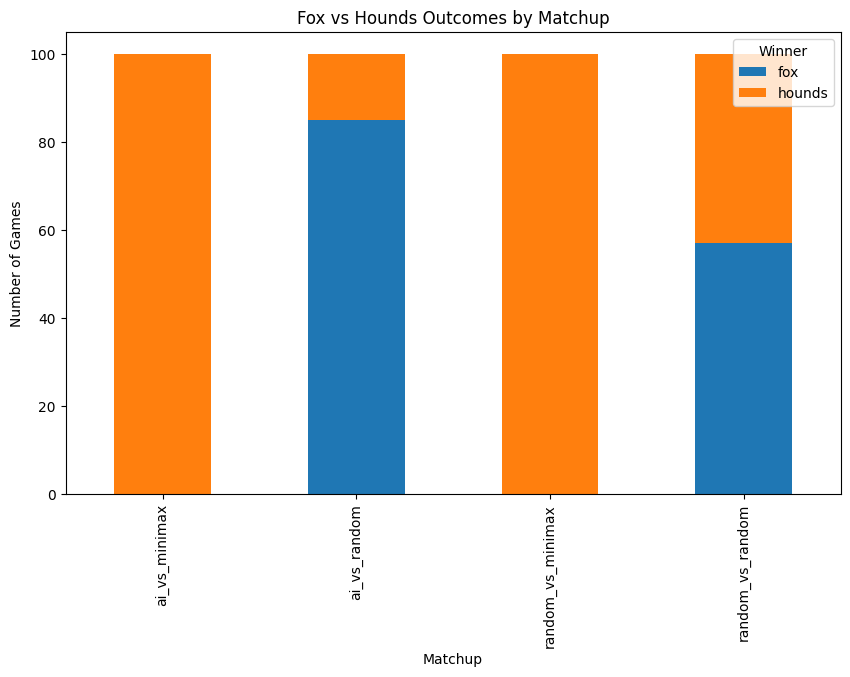

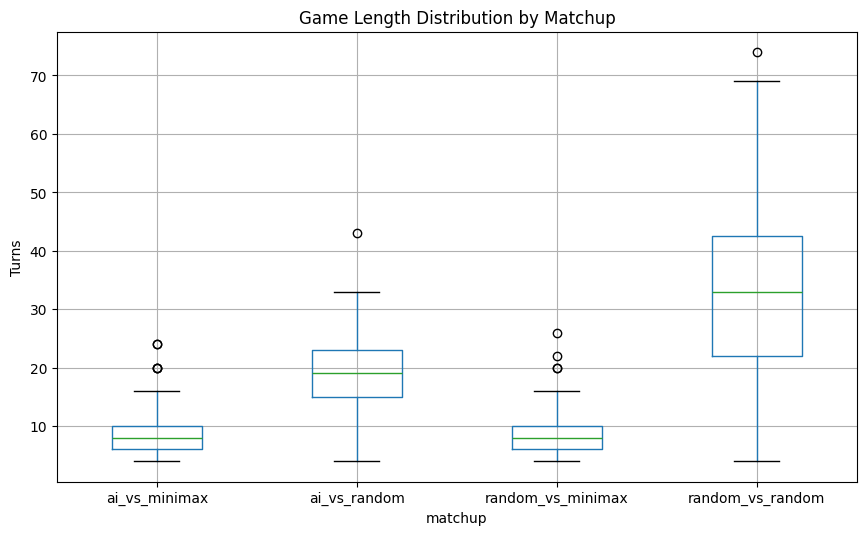

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

def aggregate_results(all_results):
    """
    Convert results dict into a DataFrame and summary stats.
    """
    records = []
    for matchup, games in all_results.items():
        for winner, turns in games:
            records.append({"matchup": matchup, "winner": winner, "turns": turns})

    df = pd.DataFrame(records)

    # Summary aggregation
    summary = df.groupby(["matchup", "winner"]).agg(
        games_played=("winner", "count"),
        avg_turns=("turns", "mean")
    ).reset_index()

    return df, summary

def plot_wins(df):
    """
    Bar chart of number of wins per matchup.
    """
    win_counts = df.groupby(["matchup", "winner"]).size().unstack(fill_value=0)

    win_counts.plot(kind="bar", stacked=True, figsize=(10,6))
    plt.title("Fox vs Hounds Outcomes by Matchup")
    plt.ylabel("Number of Games")
    plt.xlabel("Matchup")
    plt.legend(title="Winner")
    plt.show()

def plot_turns(df):
    """
    Boxplot of game length (turns) per matchup.
    """
    df.boxplot(column="turns", by="matchup", figsize=(10,6))
    plt.title("Game Length Distribution by Matchup")
    plt.suptitle("")  # remove automatic title
    plt.ylabel("Turns")
    plt.show()


all_results = run_all_matchups(100)  # run your simulations
df, summary = aggregate_results(all_results)

print("=== Summary Table ===")
print(summary)

plot_wins(df)
plot_turns(df)


## Reflection

Your report on your data needs to include charts or tables that describe the game results from your evaluation. It also needs to include two reflection paragraphs. One that describes Overall Performance (i.e. which AI won the most, least etc) and one that describes Design Decisions.

As expected, the random versus random approached 50% win rate for both parties. This means that rules of the game are balanced and confirms the hypothesis that both parties have an equal chance of winning at turn zero. Looking at the turn distribution, whenever AI guidance was involved with either party, the games were much shorter. I did not expect the Djikstra versus Random instances to take longer than Djikstra versus Minimax. The other surprise was the outlier in the random vs random game where the game took over 70 turns to complete. I also found it surprising that the Djikstra versus Random runs had as many random wins as it did. Using the results from these trial runs exemplified how "good" these AI processes are for different applications. I will keep these results in mind in the future as I implement anything graph related.

Creating the gameboard seemed like the most intensive (or tedious) part for me, as UIs usually are. We chose a mini-mx implementation for the hounds and a Djikstra shortest path implementation for the fox. The hounds implementation was much more in depth than Djikstra but the results show. Minimax beat the simple shortest path by far, since all possible moves are accounted for ahead of time and the most optimal solution is always chosen. Overall, I believe the project confirmed prior hypothesis on how the games would occur.